In [1]:
import pandas as pd
import numpy as np
import string
import re
import json
import os
import matplotlib.pyplot as plt
import warnings
import random
from utils import generate_explanation, generate_explanation_prediction, label_description_plural, get_verification_label,\
label_description_singular, generate_word_explanation, generate_word_explanation_prediction, generate_entity_explanation, \
generate_word_entity_explanation, generate_check_refer_ans, generate_dummy_check_refer_ans, generate_aggregated_word_explanation

In [2]:
tweet_dir = '/scratch/dzhang5/usda_project/tweet-fid-application'
output_dir = '/scratch/dzhang5/LLM/TWEET-FID'
label_symbol = '^^^^'

In [3]:
train_mv_name = 'mrc-ner.mv.train'
train_expert_name = 'mrc-ner.expert.train'
train_bsc_name = 'mrc-ner.bsc.train'
short_train_expert_name = 'mrc-ner.expert.train.short'
short_train_mv_name = 'mrc-ner.mv.train.short'
short_train_bsc_name = 'mrc-ner.bsc.train.short'
unlabeled_name = 'mrc-ner.unlabeled'
test_expert_name = 'mrc-ner.expert.test'
dev_expert_name = 'mrc-ner.expert.dev'
small_test_expert_name = 'mrc-ner.expert.smalltest'
dev_bsc_name = 'mrc-ner.bsc.dev'
dev_mv_name = 'mrc-ner.mv.dev'

train_dev_expert_for_test_name = 'mrc-ner.expert.traindevfortest'
train_test_expert_for_test_name = 'mrc-ner.expert.traintestfortest'
train_expert_for_test_name = 'mrc-ner.expert.trainfortest'

short_test_expert_for_train_name = 'mrc-ner.expert.testfortrain.short'
short_test_mv_for_train_name = 'mrc-ner.mv.testfortrain.short'
short_test_bsc_for_train_name = 'mrc-ner.bsc.testfortrain.short'
test_expert_for_train_name = 'mrc-ner.expert.testfortrain'
test_mv_for_train_name = 'mrc-ner.mv.testfortrain'
test_bsc_for_train_name = 'mrc-ner.bsc.testfortrain'

short_dev_expert_for_train_name = 'mrc-ner.expert.devfortrain.short'
short_dev_mv_for_train_name = 'mrc-ner.mv.devfortrain.short'
short_dev_bsc_for_train_name = 'mrc-ner.bsc.devfortrain.short'
dev_expert_for_train_name = 'mrc-ner.expert.devfortrain'
dev_mv_for_train_name = 'mrc-ner.mv.devfortrain'
dev_bsc_for_train_name = 'mrc-ner.bsc.devfortrain'

In [4]:
train_mv_data = pd.read_pickle(f"{tweet_dir}/tweet-fid/LREC_mv/train.p")
train_expert_data = pd.read_pickle(f"{tweet_dir}/tweet-fid/LREC_expert_label/train.p")
train_bsc_data = pd.read_pickle(f"{tweet_dir}/tweet-fid/LREC_BSC/train.p")
unlabeled_data = pd.read_pickle(f"{tweet_dir}/tweet-fid-unlabeled.p")

In [5]:
test_expert_data = pd.read_pickle(f"{tweet_dir}/tweet-fid/LREC_expert_label/test.p")
test_mv_data = pd.read_pickle(f"{tweet_dir}/tweet-fid/LREC_mv/test.p")
test_bsc_data = pd.read_pickle(f"{tweet_dir}/tweet-fid/LREC_BSC/test.p")
dev_expert_data = pd.read_pickle(f"{tweet_dir}/tweet-fid/LREC_expert_label/dev.p")
dev_mv_data = pd.read_pickle(f"{tweet_dir}/tweet-fid/LREC_mv/dev.p")
dev_bsc_data = pd.read_pickle(f"{tweet_dir}/tweet-fid/LREC_BSC/dev.p")

In [6]:
(test_expert_data['sentence_class'] == test_mv_data['sentence_class']).all()

True

In [7]:
(test_mv_data['sentence_class'] == test_bsc_data['sentence_class']).all()

True

In [8]:
small_test_expert_data = test_expert_data.iloc[:10].copy()

In [9]:
unlabeled_data.rename(columns={'tweet_token':"tweet_tokens"}, inplace=True)

In [10]:
unlabeled_data.rename(columns={'tweet_text':"tweet"},inplace=True)

In [11]:
unlabeled_data.rename(columns={'sentence_prediction':"sentence_class"}, inplace=True)

In [12]:
unlabeled_data['relevant_entity_label'] = unlabeled_data['token_prediction'].apply(lambda x: x.split(","))

In [13]:
train_expert_data['relevant_entity_label'].explode().unique()

array(['O', 'B-other', 'I-other', 'B-food', 'I-food', 'B-loc',
       'B-symptom', 'I-loc', 'I-symptom'], dtype=object)

In [14]:
unlabeled_data.loc[204529]['tweet']

"And then there was that time we woke up to great dane diarrhea all over our room......... 💀 \rAnyone want a dog? She's real cute😇"

In [15]:
unlabeled_data.loc[unlabeled_data['tweet'].str.contains('\r'), 'tweet'] = unlabeled_data['tweet'].loc[unlabeled_data['tweet'].str.contains('\r')].str.replace('\r', '')

In [16]:
unlabeled_data['tweet'].str.contains('\r').any()

False

In [17]:
unlabeled_data.loc[204529]['tweet']

"And then there was that time we woke up to great dane diarrhea all over our room......... 💀 Anyone want a dog? She's real cute😇"

In [18]:
unlabeled_data['tweet'].apply(lambda x: '>' in x).describe()

count     50000
unique        1
top       False
freq      50000
Name: tweet, dtype: object

In [19]:
unlabeled_data['tweet'].apply(lambda x: '^^' in x).describe()

count     50000
unique        2
top       False
freq      49997
Name: tweet, dtype: object

<AxesSubplot: >

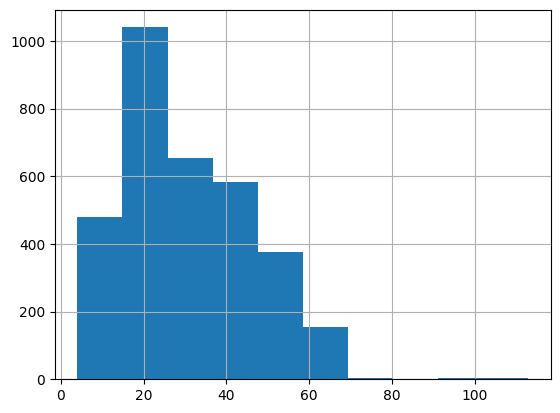

In [20]:
train_expert_data['tweet_tokens'].apply(len).hist()

<AxesSubplot: >

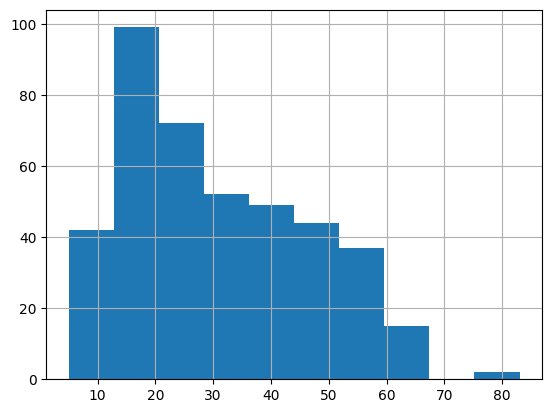

In [21]:
test_expert_data['tweet_tokens'].apply(len).hist()

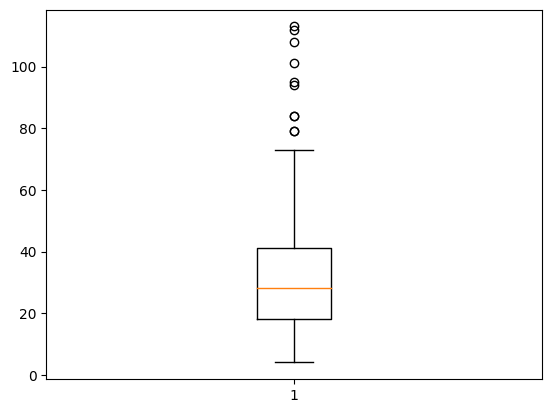

In [22]:
plt.boxplot(train_expert_data['tweet_tokens'].apply(len))
plt.show()

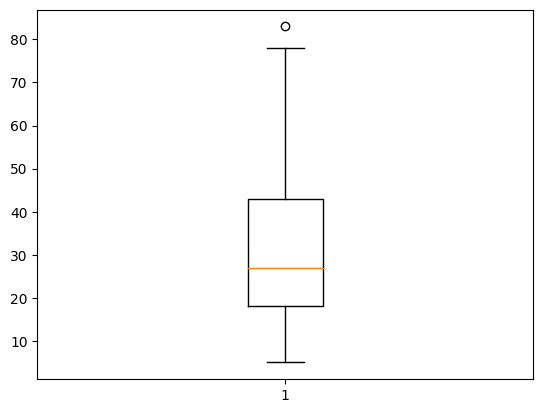

In [23]:
plt.boxplot(test_expert_data['tweet_tokens'].apply(len))
plt.show()

In [24]:
train_expert_data['tweet_tokens'].apply(len).describe()

count    3298.000000
mean       30.482717
std        15.565096
min         4.000000
25%        18.000000
50%        28.000000
75%        41.000000
max       113.000000
Name: tweet_tokens, dtype: float64

In [25]:
dev_expert_data['tweet_tokens'].apply(len).describe()

count    412.000000
mean      30.864078
std       15.392385
min        5.000000
25%       18.000000
50%       28.000000
75%       42.000000
max       94.000000
Name: tweet_tokens, dtype: float64

In [26]:
test_expert_data['tweet_tokens'].apply(len).describe()

count    412.000000
mean      30.779126
std       15.780651
min        5.000000
25%       18.000000
50%       27.000000
75%       43.000000
max       83.000000
Name: tweet_tokens, dtype: float64

In [27]:
print((test_expert_data['tweet_tokens'].apply(len) == test_expert_data['relevant_entity_label'].apply(len)).all())
print((test_mv_data['tweet_tokens'].apply(len) == test_mv_data['relevant_entity_label'].apply(len)).all())
print((test_bsc_data['tweet_tokens'].apply(len) == test_bsc_data['relevant_entity_label'].apply(len)).all())

print((train_expert_data['tweet_tokens'].apply(len) == train_expert_data['relevant_entity_label'].apply(len)).all())
print((train_mv_data['tweet_tokens'].apply(len) == train_mv_data['relevant_entity_label'].apply(len)).all())
print((train_bsc_data['tweet_tokens'].apply(len) == train_bsc_data['relevant_entity_label'].apply(len)).all())

print((dev_expert_data['tweet_tokens'].apply(len) == dev_expert_data['relevant_entity_label'].apply(len)).all())
print((dev_mv_data['tweet_tokens'].apply(len) == dev_mv_data['relevant_entity_label'].apply(len)).all())
print((dev_bsc_data['tweet_tokens'].apply(len) == dev_bsc_data['relevant_entity_label'].apply(len)).all())

True
True
True
True
True
True
True
True
True


In [28]:
print((dev_bsc_data['tweet'] == dev_expert_data['tweet']).all() and (dev_bsc_data['tweet'] == dev_mv_data['tweet']).all())
print((test_bsc_data['tweet'] == test_expert_data['tweet']).all() and (test_bsc_data['tweet'] == test_mv_data['tweet']).all())
print((train_bsc_data['tweet'] == train_expert_data['tweet']).all() and (train_bsc_data['tweet'] == train_mv_data['tweet']).all())

print((dev_bsc_data.index == dev_expert_data.index).all() and (dev_bsc_data.index == dev_mv_data.index).all())
print((test_bsc_data.index == test_expert_data.index).all() and (test_bsc_data.index == test_mv_data.index).all())
print((train_bsc_data.index == train_expert_data.index).all() and (train_bsc_data.index == train_mv_data.index).all())

True
True
True
True
True
True


In [29]:
print((dev_bsc_data['tweet_tokens'] == dev_expert_data['tweet_tokens']).all() and (dev_bsc_data['tweet_tokens'] == dev_mv_data['tweet_tokens']).all())
print((test_bsc_data['tweet_tokens'] == test_expert_data['tweet_tokens']).all() and (test_bsc_data['tweet_tokens'] == test_mv_data['tweet_tokens']).all())
print((train_bsc_data['tweet_tokens'] == train_expert_data['tweet_tokens']).all() and (train_bsc_data['tweet_tokens'] == train_mv_data['tweet_tokens']).all())

False
True
False


In [30]:
print((train_mv_data['tweet_tokens'] == train_bsc_data['tweet_tokens']).all())
print((train_mv_data['tweet_tokens'] == train_expert_data['tweet_tokens']).all())
print((train_bsc_data['tweet_tokens'] == train_expert_data['tweet_tokens']).all())
print((dev_mv_data['tweet_tokens'] == dev_expert_data['tweet_tokens']).all())
print((dev_mv_data['tweet_tokens'] == dev_bsc_data['tweet_tokens']).all())
print((dev_bsc_data['tweet_tokens'] == dev_expert_data['tweet_tokens']).all())

False
False
False
False
False
False


In [31]:
print((train_mv_data['relevant_entity_label'].apply(len) == train_bsc_data['relevant_entity_label'].apply(len)).all())
print((train_mv_data['relevant_entity_label'].apply(len) == train_expert_data['relevant_entity_label'].apply(len)).all())
print((train_bsc_data['relevant_entity_label'].apply(len) == train_expert_data['relevant_entity_label'].apply(len)).all())
print((dev_mv_data['relevant_entity_label'].apply(len) == dev_expert_data['relevant_entity_label'].apply(len)).all())
print((dev_mv_data['relevant_entity_label'].apply(len) == dev_bsc_data['relevant_entity_label'].apply(len)).all())
print((dev_bsc_data['relevant_entity_label'].apply(len) == dev_expert_data['relevant_entity_label'].apply(len)).all())
print((test_mv_data['relevant_entity_label'].apply(len) == test_expert_data['relevant_entity_label'].apply(len)).all())
print((test_mv_data['relevant_entity_label'].apply(len) == test_bsc_data['relevant_entity_label'].apply(len)).all())
print((test_bsc_data['relevant_entity_label'].apply(len) == test_expert_data['relevant_entity_label'].apply(len)).all())

False
False
False
False
False
False
True
True
True


In [32]:
print((test_mv_data['relevant_entity_label'] == test_expert_data['relevant_entity_label']).all())
print((test_mv_data['relevant_entity_label'] == test_bsc_data['relevant_entity_label']).all())
print((test_bsc_data['relevant_entity_label'] == test_expert_data['relevant_entity_label']).all())

True
True
True


In [33]:
print(train_mv_data.loc[train_mv_data['tweet_tokens'] != train_bsc_data['tweet_tokens'], 'tweet_tokens'].iloc[0])

print(train_bsc_data.loc[train_mv_data['tweet_tokens'] != train_bsc_data['tweet_tokens'], 'tweet_tokens'].iloc[0])

print(train_mv_data.loc[train_mv_data['tweet_tokens'] != train_bsc_data['tweet_tokens'], 'relevant_entity_label'].iloc[0])

print(train_bsc_data.loc[train_mv_data['tweet_tokens'] != train_bsc_data['tweet_tokens'], 'relevant_entity_label'].iloc[0])

['I', 'know', 'my', 'tubes', 'tied', 'but', 'When', 'Mother', 'Nature', 'be', 'playing', 'I', 'give', 'my', 'stomach', 'a', 'extra', 'punch', 'just', 'in', 'case', 'cause', 'bitch', "don't", 'play', 'with', 'me', '🤨', '😒', '😭']
['I', 'know', 'my', 'tubes', 'tied', 'but', 'When', 'Mother', 'Nature', 'be', 'playing', 'I', 'give', 'my', 'stomach', 'a', 'extra', 'punch', 'just', 'in', 'case', 'cause', 'bitch', "don't", 'play', 'with', 'me', '[', 'EMOJI_face_with_raised_eyebrow', ']', '[', 'EMOJI_unamused_face', ']', '[', 'EMOJI_loudly_crying_face', ']']
['O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O']
['O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O']


In [34]:
print(train_expert_data.loc[train_expert_data['tweet_tokens'] != train_bsc_data['tweet_tokens'], 'tweet_tokens'].iloc[0])

print(train_bsc_data.loc[train_expert_data['tweet_tokens'] != train_bsc_data['tweet_tokens'], 'tweet_tokens'].iloc[0])

print(train_expert_data.loc[train_expert_data['tweet_tokens'] != train_bsc_data['tweet_tokens'], 'relevant_entity_label'].iloc[0])

print(train_mv_data.loc[train_mv_data['tweet_tokens'] != train_bsc_data['tweet_tokens'], 'relevant_entity_label'].iloc[0])

['i', 'got', 'home', 'and', 'ate', 'dinner', 'so', 'mfing', 'fast', 'that', 'my', 'stomach', 'hurts', 'and', 'somehow', "i'm", 'still', '“hungry”', '?', '?', '?', 'this', "ain't", 'right']
['i', 'got', 'home', 'and', 'ate', 'dinner', 'so', 'mfing', 'fast', 'that', 'my', 'stomach', 'hurts', 'and', 'somehow', "i'm", 'still', '“', 'hungry', '”', '?', '?', '?', 'this', "ain't", 'right']
['O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O']
['O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O']


In [35]:
short_train_index = train_expert_data.loc[train_expert_data['tweet_tokens'].apply(len) <= 41].index
short_train_expert_data = train_expert_data.loc[short_train_index].copy()
short_train_mv_data = train_mv_data.loc[short_train_index].copy()
short_train_bsc_data = train_bsc_data.loc[short_train_index].copy()

short_test_index = test_expert_data.loc[test_expert_data['tweet_tokens'].apply(len) <= 43].index
short_test_expert_data_for_train = test_expert_data.loc[short_test_index].copy()
short_test_mv_data_for_train = test_mv_data.loc[short_test_index].copy()
short_test_bsc_data_for_train = test_bsc_data.loc[short_test_index].copy()

short_dev_index = dev_expert_data.loc[dev_expert_data['tweet_tokens'].apply(len) <= 42].index
short_dev_expert_data_for_train = dev_expert_data.loc[short_dev_index].copy()
short_dev_mv_data_for_train = dev_mv_data.loc[short_dev_index].copy()
short_dev_bsc_data_for_train = dev_bsc_data.loc[short_dev_index].copy()

In [36]:
train_dev_expert_data_for_test = pd.concat([train_expert_data, dev_expert_data])
train_test_expert_data_for_test = pd.concat([train_expert_data, test_expert_data])

train_expert_data_for_test = train_expert_data.copy()

dev_expert_data_for_train = dev_expert_data.copy()
dev_mv_data_for_train = dev_mv_data.copy()
dev_bsc_data_for_train = dev_bsc_data.copy()

test_expert_data_for_train = test_expert_data.copy()
test_mv_data_for_train = test_mv_data.copy()
test_bsc_data_for_train = test_bsc_data.copy()

In [37]:
def get_labeled_text(labels, tokens, label_symbol, entity_type):
    sym_len = len(label_symbol)
    label_prefix, label_suffix = label_symbol[:sym_len//2], label_symbol[sym_len//2:]
    labeled_tokens = []
    flag = False
    for label, token in zip(labels, tokens):
        if label.startswith('B-'):
            if flag:
                last_token = labeled_tokens[-1]
                last_token += label_suffix
                labeled_tokens[-1] = last_token
                flag = False
            entity_label = label[2:]
            if entity_label == entity_type:
                token = label_prefix + token
                flag = True
            labeled_tokens.append(token)
        elif label.startswith('I-'):
            entity_label = label[2:]
            if (not flag) and entity_label == entity_type:
                warnings.warn('entity label does not start with "B-"', RuntimeWarning)
                token = label_prefix + token
                flag = True
            elif flag and entity_label != entity_type:
                warnings.warn('entity type mismatch within a multi-token entity', RuntimeWarning)
            labeled_tokens.append(token)
        else:
            if flag:
                last_token = labeled_tokens[-1]
                last_token += label_suffix
                labeled_tokens[-1] = last_token
                flag = False
            labeled_tokens.append(token)
    if flag:
        last_token = labeled_tokens[-1]
        last_token += label_suffix
        labeled_tokens[-1] = last_token
        flag = False
    return " ".join(labeled_tokens)

def convert_label_format(label):
    if label == 1:
        return 'Yes'
    elif label == 0:
        return 'No'
    else:
        return label

def convert_entity_label(labels, tokens, return_type):
    name_map = {'food': "Food", 'loc': "Location", 'symptom': "Symptom", 'other': "Keyword"}
    entities = {v: [] for k, v in name_map.items()}
    ind_end = []
    current_entity = None
    start_position = None

    for i, label in enumerate(labels):
        if label.startswith('B-'):
            if current_entity is not None:
                # Save the previous entity
                entities[name_map[current_entity]].append(" ".join(tokens[start_position: i]))
                ind_end.append({"Description": name_map[current_entity], "Text": " ".join(tokens[start_position: i])})
            # Start a new entity
            current_entity = label.split('-')[1]
            start_position = i

        elif label.startswith('I-') and current_entity is not None:
            # Continue the current entity
            continue

        else:
            # End of an entity
            if current_entity is not None:
                # Save the current entity
                entities[name_map[current_entity]].append(' '.join(tokens[start_position: i]))
                ind_end.append({"Description": name_map[current_entity], "Text": " ".join(tokens[start_position: i])})
                current_entity = None

    # Check for the last entity
    if current_entity is not None:
        entities[name_map[current_entity]].append(' '.join(tokens[start_position: len(labels)]))
        ind_end.append({"Description": name_map[current_entity], "Text": " ".join(tokens[start_position: len(labels)])})

    if return_type == 'dict':
        return json.dumps(entities)
    else:
        return ind_end

def check_entity_existence(labels, check_type):
    labels = json.loads(labels)
    for k, v in labels.items():
        if check_type == 'all' or k == check_type:
            if v:
                return 'yes'
    return 'no'
    

def convert_label_column(df, label_symbol, mode='train'):
    df['sentence_class'] = df['sentence_class'].apply(lambda x: convert_label_format(x))
    df['IndividualLabels'] = df[['relevant_entity_label', 'tweet_tokens']].apply(lambda x: convert_entity_label(x['relevant_entity_label'], x['tweet_tokens'], 'list'), axis=1)
    df['CategorizedLabels'] = df[['relevant_entity_label', 'tweet_tokens']].apply(lambda x: convert_entity_label(x['relevant_entity_label'], x['tweet_tokens'], 'dict'), axis=1)
    df['Food_answer'] = df[['relevant_entity_label', 'tweet_tokens']].apply(lambda x: get_labeled_text(x['relevant_entity_label'], x['tweet_tokens'], label_symbol, 'food'), axis=1)
    df['Location_answer'] = df[['relevant_entity_label', 'tweet_tokens']].apply(lambda x: get_labeled_text(x['relevant_entity_label'], x['tweet_tokens'], label_symbol, 'loc'), axis=1)
    df['Symptom_answer'] = df[['relevant_entity_label', 'tweet_tokens']].apply(lambda x: get_labeled_text(x['relevant_entity_label'], x['tweet_tokens'], label_symbol, 'symptom'), axis=1)
    df['Keyword_answer'] = df[['relevant_entity_label', 'tweet_tokens']].apply(lambda x: get_labeled_text(x['relevant_entity_label'], x['tweet_tokens'], label_symbol, 'other'), axis=1)
    for et in ["Food", "Location", "Symptom", "Keyword", "all"]:
        df[f'has_{et}'] = df['CategorizedLabels'].apply(lambda x: check_entity_existence(x, et))
    df['context'] = df['tweet_tokens'].apply(lambda x: " ".join(x))
    if mode == 'train':
        df['sentence_explanation'] = df[['CategorizedLabels', 'sentence_class']].apply(lambda x: generate_explanation_prediction(x['CategorizedLabels'], x['sentence_class']), axis=1)
        df['entity_explanation'] = df[['CategorizedLabels', 'sentence_class']].apply(lambda x: generate_aggregated_word_explanation(x['CategorizedLabels'], x['sentence_class']), axis=1)
        df['sentence_explanation_prediction'] = df[['CategorizedLabels', 'sentence_class']].apply(lambda x: generate_explanation_prediction(x['CategorizedLabels'], x['sentence_class']), axis=1)
        df['word_explanation'] = df['sentence_class'].apply(generate_word_explanation)
        df['word_explanation_prediction'] = df['sentence_class'].apply(generate_word_explanation_prediction)
        df[['Food_explanation', 'Location_explanation', 'Symptom_explanation', 'Keyword_explanation']] = df[['CategorizedLabels']].apply(lambda x: generate_entity_explanation(x['CategorizedLabels']), axis=1, result_type='expand')
        df[['Two_step_Food_explanation', 'Two_step_Location_explanation', 'Two_step_Symptom_explanation', 'Two_step_Keyword_explanation']] = df[['sentence_class', 'CategorizedLabels']].apply(lambda x: generate_word_entity_explanation(x['sentence_class'], x['CategorizedLabels']), axis=1, result_type='expand')
        df[['sentence_check_reference', 'sentence_check_explanation', 'sentence_check_class']] = df[['CategorizedLabels', 'tweet_tokens', 'sentence_class']].apply(lambda x: generate_check_refer_ans(x['CategorizedLabels'], x['tweet_tokens'], x['sentence_class']), axis=1, result_type='expand')
        df[['dummy_sentence_check_reference', 'dummy_sentence_check_explanation', 'dummy_sentence_check_class']] = df[['CategorizedLabels', 'tweet_tokens', 'sentence_class']].apply(lambda x: generate_dummy_check_refer_ans(x['CategorizedLabels'], x['tweet_tokens'], x['sentence_class']), axis=1, result_type='expand')
    else:
        df['sentence_explanation'] = df[['CategorizedLabels', 'sentence_class']].apply(lambda x: generate_explanation_prediction(x['CategorizedLabels'], x['sentence_class']), axis=1)
        df['word_explanation'] = df['sentence_class'].apply(generate_word_explanation)

In [38]:
random.seed(1)

In [39]:
convert_label_column(train_mv_data, label_symbol, 'train')
convert_label_column(train_expert_data, label_symbol, 'train')
convert_label_column(train_bsc_data, label_symbol, 'train')
convert_label_column(unlabeled_data, label_symbol, 'test')
convert_label_column(test_expert_data, label_symbol, 'test')
convert_label_column(dev_expert_data, label_symbol, 'dev')
convert_label_column(dev_bsc_data, label_symbol, 'dev')
convert_label_column(dev_mv_data, label_symbol, 'dev')
convert_label_column(small_test_expert_data, label_symbol, 'test')
convert_label_column(short_train_expert_data, label_symbol, 'train')
convert_label_column(short_train_mv_data, label_symbol, 'train')
convert_label_column(short_train_bsc_data, label_symbol, 'train')

/scratch/dzhang5/LLM/utils.py:185: UserWarning: This text is labeled as indicating foodborne illness but no word is labeled related to foodborne illness
  warnings.warn("This text is labeled as indicating foodborne illness but "
/scratch/dzhang5/LLM/utils.py:185: UserWarning: This text is labeled as indicating foodborne illness but no word is labeled related to foodborne illness
  warnings.warn("This text is labeled as indicating foodborne illness but "
/scratch/dzhang5/LLM/utils.py:185: UserWarning: This text is labeled as indicating foodborne illness but no word is labeled related to foodborne illness
  warnings.warn("This text is labeled as indicating foodborne illness but "
/scratch/dzhang5/LLM/utils.py:185: UserWarning: This text is labeled as indicating foodborne illness but no word is labeled related to foodborne illness
  warnings.warn("This text is labeled as indicating foodborne illness but "
/tmp/ipykernel_2970633/989393008.py:21: RuntimeWarning: entity label does not start 

In [40]:
convert_label_column(short_dev_expert_data_for_train, label_symbol, 'train')
convert_label_column(short_dev_mv_data_for_train, label_symbol, 'train')
convert_label_column(short_dev_bsc_data_for_train, label_symbol, 'train')
convert_label_column(short_test_expert_data_for_train, label_symbol, 'train')
convert_label_column(short_test_mv_data_for_train, label_symbol, 'train')
convert_label_column(short_test_bsc_data_for_train, label_symbol, 'train')

convert_label_column(dev_expert_data_for_train, label_symbol, 'train')
convert_label_column(dev_mv_data_for_train, label_symbol, 'train')
convert_label_column(dev_bsc_data_for_train, label_symbol, 'train')
convert_label_column(test_expert_data_for_train, label_symbol, 'train')
convert_label_column(test_mv_data_for_train, label_symbol, 'train')
convert_label_column(test_bsc_data_for_train, label_symbol, 'train')

convert_label_column(train_dev_expert_data_for_test, label_symbol, 'test')
convert_label_column(train_test_expert_data_for_test, label_symbol, 'test')
convert_label_column(train_expert_data_for_test, label_symbol, 'test')

/scratch/dzhang5/LLM/utils.py:185: UserWarning: This text is labeled as indicating foodborne illness but no word is labeled related to foodborne illness
  warnings.warn("This text is labeled as indicating foodborne illness but "
/scratch/dzhang5/LLM/utils.py:185: UserWarning: This text is labeled as indicating foodborne illness but no word is labeled related to foodborne illness
  warnings.warn("This text is labeled as indicating foodborne illness but "
/scratch/dzhang5/LLM/utils.py:185: UserWarning: This text is labeled as indicating foodborne illness but no word is labeled related to foodborne illness
  warnings.warn("This text is labeled as indicating foodborne illness but "
/scratch/dzhang5/LLM/utils.py:185: UserWarning: This text is labeled as indicating foodborne illness but no word is labeled related to foodborne illness
  warnings.warn("This text is labeled as indicating foodborne illness but "
/scratch/dzhang5/LLM/utils.py:185: UserWarning: This text is labeled as indicating f

In [41]:
short_dev_expert_data_for_train['has_Food'].value_counts()

has_Food
no     287
yes     24
Name: count, dtype: int64

In [42]:
short_dev_mv_data_for_train['has_Food'].value_counts()

has_Food
no     278
yes     33
Name: count, dtype: int64

In [43]:
len(short_dev_expert_data_for_train) == len(short_dev_mv_data_for_train) == len(short_dev_bsc_data_for_train) 

True

In [44]:
short_dev_mv_data_for_train.columns.difference(short_dev_bsc_data_for_train.columns)

Index(['related_label', 'relevance_entity_class_label'], dtype='object')

In [45]:
name_list = [train_mv_name, train_expert_name, train_bsc_name, short_train_mv_name, short_train_expert_name, short_train_bsc_name]
data_list = [train_mv_data, train_expert_data, train_bsc_data, short_train_mv_data, short_train_expert_data, short_train_bsc_data]
for the_name, the_data in zip(name_list, data_list):
    output_path = os.path.join(output_dir, the_name.replace('mrc-ner.', '') + '.csv')
    the_data.to_csv(output_path, index=False)
    the_data.to_pickle(output_path.replace('.csv', '.pkl'))

In [46]:
name_list = [test_expert_name, dev_expert_name, dev_bsc_name, dev_mv_name, unlabeled_name, small_test_expert_name]
data_list = [test_expert_data, dev_expert_data, dev_bsc_data, dev_mv_data, unlabeled_data, small_test_expert_data]
for the_name, the_data in zip(name_list, data_list):
    output_path = os.path.join(output_dir, the_name.replace('mrc-ner.', '') + '.csv')
    the_data.to_csv(output_path, index=False)
    the_data.to_pickle(output_path.replace('.csv', '.pkl'))

In [47]:
name_list = [short_dev_expert_for_train_name, short_dev_mv_for_train_name, short_dev_bsc_for_train_name]
data_list = [short_dev_expert_data_for_train, short_dev_mv_data_for_train, short_dev_bsc_data_for_train]
for the_name, the_data in zip(name_list, data_list):
    output_path = os.path.join(output_dir, the_name.replace('mrc-ner.', '1.0.') + '.csv')
    the_data.to_csv(output_path, index=False)
    the_data.to_pickle(output_path.replace('.csv', '.pkl'))
    half_path = os.path.join(output_dir, the_name.replace('mrc-ner.', '0.5.') + '.csv')
    half_data = the_data.sample(frac=0.5, replace=False, random_state=1)
    half_data.to_csv(half_path, index=False)
    half_data.to_pickle(half_path.replace('.csv', '.pkl'))
    quar_path = os.path.join(output_dir, the_name.replace('mrc-ner.', '0.25.') + '.csv')
    quar_data = the_data.sample(frac=0.25, replace=False, random_state=1)
    quar_data.to_csv(quar_path, index=False)
    quar_data.to_pickle(quar_path.replace('.csv', '.pkl'))
    eigh_path = os.path.join(output_dir, the_name.replace('mrc-ner.', '0.125.') + '.csv')
    eigh_data = the_data.sample(frac=0.125, replace=False, random_state=1)
    eigh_data.to_csv(eigh_path, index=False)
    eigh_data.to_pickle(eigh_path.replace('.csv', '.pkl'))
    sixt_path = os.path.join(output_dir, the_name.replace('mrc-ner.', '0.0625.') + '.csv')
    sixt_data = the_data.sample(frac=0.0625, replace=False, random_state=1)
    sixt_data.to_csv(sixt_path, index=False)
    sixt_data.to_pickle(sixt_path.replace('.csv', '.pkl'))
    thir_path = os.path.join(output_dir, the_name.replace('mrc-ner.', '0.03125.') + '.csv')
    thir_data = the_data.sample(frac=0.03125, replace=False, random_state=1)
    thir_data.to_csv(thir_path, index=False)
    thir_data.to_pickle(thir_path.replace('.csv', '.pkl'))

In [48]:
name_list = [dev_expert_for_train_name, dev_mv_for_train_name, dev_bsc_for_train_name]
data_list = [dev_expert_data_for_train, dev_mv_data_for_train, dev_bsc_data_for_train]
for the_name, the_data in zip(name_list, data_list):
    output_path = os.path.join(output_dir, the_name.replace('mrc-ner.', '1.0.') + '.csv')
    the_data.to_csv(output_path, index=False)
    the_data.to_pickle(output_path.replace('.csv', '.pkl'))
    half_path = os.path.join(output_dir, the_name.replace('mrc-ner.', '0.5.') + '.csv')
    half_data = the_data.sample(frac=0.5, replace=False, random_state=1)
    half_data.to_csv(half_path, index=False)
    half_data.to_pickle(half_path.replace('.csv', '.pkl'))
    quar_path = os.path.join(output_dir, the_name.replace('mrc-ner.', '0.25.') + '.csv')
    quar_data = the_data.sample(frac=0.25, replace=False, random_state=1)
    quar_data.to_csv(quar_path, index=False)
    quar_data.to_pickle(quar_path.replace('.csv', '.pkl'))
    eigh_path = os.path.join(output_dir, the_name.replace('mrc-ner.', '0.125.') + '.csv')
    eigh_data = the_data.sample(frac=0.125, replace=False, random_state=1)
    eigh_data.to_csv(eigh_path, index=False)
    eigh_data.to_pickle(eigh_path.replace('.csv', '.pkl'))
    sixt_path = os.path.join(output_dir, the_name.replace('mrc-ner.', '0.0625.') + '.csv')
    sixt_data = the_data.sample(frac=0.0625, replace=False, random_state=1)
    sixt_data.to_csv(sixt_path, index=False)
    sixt_data.to_pickle(sixt_path.replace('.csv', '.pkl'))
    thir_path = os.path.join(output_dir, the_name.replace('mrc-ner.', '0.03125.') + '.csv')
    thir_data = the_data.sample(frac=0.03125, replace=False, random_state=1)
    thir_data.to_csv(thir_path, index=False)
    thir_data.to_pickle(thir_path.replace('.csv', '.pkl'))

In [49]:
name_list = [short_test_expert_for_train_name, short_test_mv_for_train_name, short_test_bsc_for_train_name]
data_list = [short_test_expert_data_for_train, short_test_mv_data_for_train, short_test_bsc_data_for_train]
for the_name, the_data in zip(name_list, data_list):
    output_path = os.path.join(output_dir, the_name.replace('mrc-ner.', '1.0.') + '.csv')
    the_data.to_csv(output_path, index=False)
    the_data.to_pickle(output_path.replace('.csv', '.pkl'))
    half_path = os.path.join(output_dir, the_name.replace('mrc-ner.', '0.5.') + '.csv')
    half_data = the_data.sample(frac=0.5, replace=False, random_state=1)
    half_data.to_csv(half_path, index=False)
    half_data.to_pickle(half_path.replace('.csv', '.pkl'))
    quar_path = os.path.join(output_dir, the_name.replace('mrc-ner.', '0.25.') + '.csv')
    quar_data = the_data.sample(frac=0.25, replace=False, random_state=1)
    quar_data.to_csv(quar_path, index=False)
    quar_data.to_pickle(quar_path.replace('.csv', '.pkl'))
    eigh_path = os.path.join(output_dir, the_name.replace('mrc-ner.', '0.125.') + '.csv')
    eigh_data = the_data.sample(frac=0.125, replace=False, random_state=1)
    eigh_data.to_csv(eigh_path, index=False)
    eigh_data.to_pickle(eigh_path.replace('.csv', '.pkl'))
    sixt_path = os.path.join(output_dir, the_name.replace('mrc-ner.', '0.0625.') + '.csv')
    sixt_data = the_data.sample(frac=0.0625, replace=False, random_state=1)
    sixt_data.to_csv(sixt_path, index=False)
    sixt_data.to_pickle(sixt_path.replace('.csv', '.pkl'))
    thir_path = os.path.join(output_dir, the_name.replace('mrc-ner.', '0.03125.') + '.csv')
    thir_data = the_data.sample(frac=0.03125, replace=False, random_state=1)
    thir_data.to_csv(thir_path, index=False)
    thir_data.to_pickle(thir_path.replace('.csv', '.pkl'))

In [50]:
name_list = [test_expert_for_train_name, test_mv_for_train_name, test_bsc_for_train_name]
data_list = [test_expert_data_for_train, test_mv_data_for_train, test_bsc_data_for_train]
for the_name, the_data in zip(name_list, data_list):
    output_path = os.path.join(output_dir, the_name.replace('mrc-ner.', '1.0.') + '.csv')
    the_data.to_csv(output_path, index=False)
    the_data.to_pickle(output_path.replace('.csv', '.pkl'))
    half_path = os.path.join(output_dir, the_name.replace('mrc-ner.', '0.5.') + '.csv')
    half_data = the_data.sample(frac=0.5, replace=False, random_state=1)
    half_data.to_csv(half_path, index=False)
    half_data.to_pickle(half_path.replace('.csv', '.pkl'))
    quar_path = os.path.join(output_dir, the_name.replace('mrc-ner.', '0.25.') + '.csv')
    quar_data = the_data.sample(frac=0.25, replace=False, random_state=1)
    quar_data.to_csv(quar_path, index=False)
    quar_data.to_pickle(quar_path.replace('.csv', '.pkl'))
    eigh_path = os.path.join(output_dir, the_name.replace('mrc-ner.', '0.125.') + '.csv')
    eigh_data = the_data.sample(frac=0.125, replace=False, random_state=1)
    eigh_data.to_csv(eigh_path, index=False)
    eigh_data.to_pickle(eigh_path.replace('.csv', '.pkl'))
    sixt_path = os.path.join(output_dir, the_name.replace('mrc-ner.', '0.0625.') + '.csv')
    sixt_data = the_data.sample(frac=0.0625, replace=False, random_state=1)
    sixt_data.to_csv(sixt_path, index=False)
    sixt_data.to_pickle(sixt_path.replace('.csv', '.pkl'))
    thir_path = os.path.join(output_dir, the_name.replace('mrc-ner.', '0.03125.') + '.csv')
    thir_data = the_data.sample(frac=0.03125, replace=False, random_state=1)
    thir_data.to_csv(thir_path, index=False)
    thir_data.to_pickle(thir_path.replace('.csv', '.pkl'))

In [51]:
name_list = [train_dev_expert_for_test_name, train_test_expert_for_test_name, train_expert_for_test_name]
data_list = [train_dev_expert_data_for_test, train_test_expert_data_for_test, train_expert_data_for_test]
for the_name, the_data in zip(name_list, data_list):
    output_path = os.path.join(output_dir, the_name.replace('mrc-ner.', '') + '.csv')
    the_data.to_csv(output_path, index=False)
    the_data.to_pickle(output_path.replace('.csv', '.pkl'))

In [52]:
for i in range(20):
    batch_data = unlabeled_data.iloc[i*2500:(i+1)*2500]
    batch_un_path = os.path.join(output_dir, f'unlabeled-{i+1}' + '.csv')
    batch_data.to_csv(batch_un_path, index=False)

In [53]:
def get_verify_df(df):
    df = df.copy()
    return_list = []
    for entity_type in ["Food", "Location", "Symptom", "Keyword"]:
        df[[f'{entity_type}_verify_question', f'{entity_type}_verify_answer', f'{entity_type}_verify_explanation']] = df[[f'has_{entity_type}','tweet_tokens', 'CategorizedLabels']].apply(lambda x: get_verification_label(x[f'has_{entity_type}'], x['tweet_tokens'], x['CategorizedLabels'], entity_type), axis=1, result_type="expand")
        s_list, q_list, a_list, es_list, ex_list = [], [], [], [], []
        for i in range(len(df)):
            sq_list = df[f'{entity_type}_verify_question'].iloc[i]
            sa_list = df[f'{entity_type}_verify_answer'].iloc[i]
            sen = df['context'].iloc[i]
            es = df[f'has_{entity_type}'].iloc[i]
            sex_list = df[f'{entity_type}_verify_explanation'].iloc[i]
            for q, a, ex in zip(sq_list, sa_list, sex_list):
                q_list.append(q)
                a_list.append(a)
                s_list.append(sen)
                es_list.append(es)
                ex_list.append(ex)
        return_list.append(pd.DataFrame({'context':s_list, f'{entity_type}_verify_question':q_list, f'{entity_type}_verify_answer':a_list, f'{entity_type}_verify_explanation':ex_list, f'has_{entity_type}':es_list}))
    return return_list

In [54]:
random.seed(1)

In [55]:
verify_short_train_expert_list = get_verify_df(short_train_expert_data)
verify_short_train_mv_list = get_verify_df(short_train_mv_data)
verify_short_train_bsc_list = get_verify_df(short_train_bsc_data)
verify_train_mv_list = get_verify_df(train_mv_data)
verify_train_bsc_list = get_verify_df(train_bsc_data)
verify_train_expert_list = get_verify_df(train_expert_data)

In [56]:
verify_short_dev_expert_for_train_list = get_verify_df(short_dev_expert_data_for_train)
verify_short_dev_mv_for_train_list = get_verify_df(short_dev_mv_data_for_train)
verify_short_dev_bsc_for_train_list = get_verify_df(short_dev_bsc_data_for_train)

verify_dev_mv_for_train_list = get_verify_df(dev_mv_data_for_train)
verify_dev_bsc_for_train_list = get_verify_df(dev_bsc_data_for_train)
verify_dev_expert_for_train_list = get_verify_df(dev_expert_data_for_train)

In [57]:
verify_short_test_expert_for_train_list = get_verify_df(short_test_expert_data_for_train)
verify_short_test_mv_for_train_list = get_verify_df(short_test_mv_data_for_train)
verify_short_test_bsc_for_train_list = get_verify_df(short_test_bsc_data_for_train)

verify_test_mv_for_train_list = get_verify_df(test_mv_data_for_train)
verify_test_bsc_for_train_list = get_verify_df(test_bsc_data_for_train)
verify_test_expert_for_train_list = get_verify_df(test_expert_data_for_train)

In [58]:
et_list = ["Food", "Location", "Symptom", "Keyword"]
for i, et in enumerate(et_list):
    output_train_mv_path = os.path.join(output_dir, train_mv_name.replace('mrc-ner.', f'{et}-verify.') + '.csv')
    verify_train_mv_list[i].to_csv(output_train_mv_path, index=False)

    output_train_expert_path = os.path.join(output_dir, train_expert_name.replace('mrc-ner.', f'{et}-verify.') + '.csv')
    verify_train_expert_list[i].to_csv(output_train_expert_path, index=False)

    output_train_bsc_path = os.path.join(output_dir, train_bsc_name.replace('mrc-ner.', f'{et}-verify.') + '.csv')
    verify_train_bsc_list[i].to_csv(output_train_bsc_path, index=False)

    output_short_train_mv_path = os.path.join(output_dir, short_train_mv_name.replace('mrc-ner.', f'{et}-verify.') + '.csv')
    verify_short_train_mv_list[i].to_csv(output_short_train_mv_path, index=False)

    output_short_train_expert_path = os.path.join(output_dir, short_train_expert_name.replace('mrc-ner.', f'{et}-verify.') + '.csv')
    verify_short_train_expert_list[i].to_csv(output_short_train_expert_path, index=False)

    output_short_train_bsc_path = os.path.join(output_dir, short_train_bsc_name.replace('mrc-ner.', f'{et}-verify.') + '.csv')
    verify_short_train_bsc_list[i].to_csv(output_short_train_bsc_path, index=False)

In [59]:
verify_data_list = [verify_short_dev_expert_for_train_list, verify_short_dev_mv_for_train_list, verify_short_dev_bsc_for_train_list]
verify_name_list = [short_dev_expert_for_train_name, short_dev_mv_for_train_name, short_dev_bsc_for_train_name]
for the_name, the_dlist in zip(verify_name_list, verify_data_list):
    et_list = ["Food", "Location", "Symptom", "Keyword"]
    for i, et in enumerate(et_list):
        output_path = os.path.join(output_dir, the_name.replace('mrc-ner.', f'{et}-verify.1.0.') + '.csv')
        the_dlist[i].to_csv(output_path, index=False)
        half_path = os.path.join(output_dir, the_name.replace('mrc-ner.', f'{et}-verify.0.5.') + '.csv')
        half_data = the_dlist[i].sample(frac=0.5, replace=False, random_state=1)
        half_data.to_csv(half_path, index=False)
        quar_path = os.path.join(output_dir, the_name.replace('mrc-ner.', f'{et}-verify.0.25.') + '.csv')
        quar_data = the_dlist[i].sample(frac=0.25, replace=False, random_state=1)
        quar_data.to_csv(quar_path, index=False)
        eigh_path = os.path.join(output_dir, the_name.replace('mrc-ner.', f'{et}-verify.0.125.') + '.csv')
        eigh_data = the_dlist[i].sample(frac=0.125, replace=False, random_state=1)
        eigh_data.to_csv(eigh_path, index=False)
        sixt_path = os.path.join(output_dir, the_name.replace('mrc-ner.', f'{et}-verify.0.0625.') + '.csv')
        sixt_data = the_dlist[i].sample(frac=0.0625, replace=False, random_state=1)
        sixt_data.to_csv(sixt_path, index=False)
        thir_path = os.path.join(output_dir, the_name.replace('mrc-ner.', f'{et}-verify.0.03125.') + '.csv')
        thir_data = the_dlist[i].sample(frac=0.03125, replace=False, random_state=1)
        thir_data.to_csv(thir_path, index=False)

In [60]:
verify_data_list = [verify_dev_expert_for_train_list, verify_dev_mv_for_train_list, verify_dev_bsc_for_train_list]
verify_name_list = [dev_expert_for_train_name, dev_mv_for_train_name, dev_bsc_for_train_name]
for the_name, the_dlist in zip(verify_name_list, verify_data_list):
    et_list = ["Food", "Location", "Symptom", "Keyword"]
    for i, et in enumerate(et_list):
        output_path = os.path.join(output_dir, the_name.replace('mrc-ner.', f'{et}-verify.1.0.') + '.csv')
        the_dlist[i].to_csv(output_path, index=False)
        half_path = os.path.join(output_dir, the_name.replace('mrc-ner.', f'{et}-verify.0.5.') + '.csv')
        half_data = the_dlist[i].sample(frac=0.5, replace=False, random_state=1)
        half_data.to_csv(half_path, index=False)
        quar_path = os.path.join(output_dir, the_name.replace('mrc-ner.', f'{et}-verify.0.25.') + '.csv')
        quar_data = the_dlist[i].sample(frac=0.25, replace=False, random_state=1)
        quar_data.to_csv(quar_path, index=False)
        eigh_path = os.path.join(output_dir, the_name.replace('mrc-ner.', f'{et}-verify.0.125.') + '.csv')
        eigh_data = the_dlist[i].sample(frac=0.125, replace=False, random_state=1)
        eigh_data.to_csv(eigh_path, index=False)
        sixt_path = os.path.join(output_dir, the_name.replace('mrc-ner.', f'{et}-verify.0.0625.') + '.csv')
        sixt_data = the_dlist[i].sample(frac=0.0625, replace=False, random_state=1)
        sixt_data.to_csv(sixt_path, index=False)
        thir_path = os.path.join(output_dir, the_name.replace('mrc-ner.', f'{et}-verify.0.03125.') + '.csv')
        thir_data = the_dlist[i].sample(frac=0.03125, replace=False, random_state=1)
        thir_data.to_csv(thir_path, index=False)

In [61]:
verify_data_list = [verify_short_test_expert_for_train_list, verify_short_test_mv_for_train_list, verify_short_test_bsc_for_train_list]
verify_name_list = [short_test_expert_for_train_name, short_test_mv_for_train_name, short_test_bsc_for_train_name]
for the_name, the_dlist in zip(verify_name_list, verify_data_list):
    et_list = ["Food", "Location", "Symptom", "Keyword"]
    for i, et in enumerate(et_list):
        output_path = os.path.join(output_dir, the_name.replace('mrc-ner.', f'{et}-verify.1.0.') + '.csv')
        the_dlist[i].to_csv(output_path, index=False)
        half_path = os.path.join(output_dir, the_name.replace('mrc-ner.', f'{et}-verify.0.5.') + '.csv')
        half_data = the_dlist[i].sample(frac=0.5, replace=False, random_state=1)
        half_data.to_csv(half_path, index=False)
        quar_path = os.path.join(output_dir, the_name.replace('mrc-ner.', f'{et}-verify.0.25.') + '.csv')
        quar_data = the_dlist[i].sample(frac=0.25, replace=False, random_state=1)
        quar_data.to_csv(quar_path, index=False)
        eigh_path = os.path.join(output_dir, the_name.replace('mrc-ner.', f'{et}-verify.0.125.') + '.csv')
        eigh_data = the_dlist[i].sample(frac=0.125, replace=False, random_state=1)
        eigh_data.to_csv(eigh_path, index=False)
        sixt_path = os.path.join(output_dir, the_name.replace('mrc-ner.', f'{et}-verify.0.0625.') + '.csv')
        sixt_data = the_dlist[i].sample(frac=0.0625, replace=False, random_state=1)
        sixt_data.to_csv(sixt_path, index=False)
        thir_path = os.path.join(output_dir, the_name.replace('mrc-ner.', f'{et}-verify.0.03125.') + '.csv')
        thir_data = the_dlist[i].sample(frac=0.03125, replace=False, random_state=1)
        thir_data.to_csv(thir_path, index=False)

In [62]:
verify_data_list = [verify_test_expert_for_train_list, verify_test_mv_for_train_list, verify_test_bsc_for_train_list]
verify_name_list = [test_expert_for_train_name, test_mv_for_train_name, test_bsc_for_train_name]
for the_name, the_dlist in zip(verify_name_list, verify_data_list):
    et_list = ["Food", "Location", "Symptom", "Keyword"]
    for i, et in enumerate(et_list):
        output_path = os.path.join(output_dir, the_name.replace('mrc-ner.', f'{et}-verify.1.0.') + '.csv')
        the_dlist[i].to_csv(output_path, index=False)
        half_path = os.path.join(output_dir, the_name.replace('mrc-ner.', f'{et}-verify.0.5.') + '.csv')
        half_data = the_dlist[i].sample(frac=0.5, replace=False, random_state=1)
        half_data.to_csv(half_path, index=False)
        quar_path = os.path.join(output_dir, the_name.replace('mrc-ner.', f'{et}-verify.0.25.') + '.csv')
        quar_data = the_dlist[i].sample(frac=0.25, replace=False, random_state=1)
        quar_data.to_csv(quar_path, index=False)
        eigh_path = os.path.join(output_dir, the_name.replace('mrc-ner.', f'{et}-verify.0.125.') + '.csv')
        eigh_data = the_dlist[i].sample(frac=0.125, replace=False, random_state=1)
        eigh_data.to_csv(eigh_path, index=False)
        sixt_path = os.path.join(output_dir, the_name.replace('mrc-ner.', f'{et}-verify.0.0625.') + '.csv')
        sixt_data = the_dlist[i].sample(frac=0.0625, replace=False, random_state=1)
        sixt_data.to_csv(sixt_path, index=False)
        thir_path = os.path.join(output_dir, the_name.replace('mrc-ner.', f'{et}-verify.0.03125.') + '.csv')
        thir_data = the_dlist[i].sample(frac=0.03125, replace=False, random_state=1)
        thir_data.to_csv(thir_path, index=False)